# Imports

In [116]:
import os
from datetime import datetime, timedelta
import pandas as pd
from xgboost import XGBRegressor
import json
import time

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch

import hopsworks

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Stores Retrieval from Hopsworks

## Login & Retrieve All Feature Stores

In [117]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

2025-11-10 14:55:37,130 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 14:55:37,135 INFO: Initializing external client
2025-11-10 14:55:37,136 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 14:55:38,549 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307


## Retrieve Air Quality and Wind Feature Stores

In [118]:
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1
)

weather_fg = fs.get_feature_group(
    name="weather",
    version=1
)

# Show what you actually got back for each FG call
print("air_quality_fg:", "Loaded" if air_quality_fg is not None else "Not Loaded")
print("weather_fg:", "Loaded" if weather_fg is not None else "Not Loaded")

air_quality_fg: Loaded
weather_fg: Loaded


# Feature View Creation

Join different feature groups (i.e., pm25, air speed and direction) together.

In [119]:
selected_features = air_quality_fg.select(["pm25", "date"]).join(
    weather_fg.select_features(), on=["city"]
)

2025-11-10 14:55:43,088 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'temp_roll_mean_3', 'wind_speed_roll_mean_3', 'temp_roll_mean_7', 'wind_speed_roll_mean_7'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


Create a feature view - selection of features from different feature groups that define I/O API of a model.

In [121]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_weather_features",
    version=1,
    description="Feature view with air quality and weather features",
    labels=['pm25'],
    query=selected_features
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286307/fs/1265775/fv/air_quality_weather_features/version/1


# Splitting the Data into Train/Test Data Sets

In [122]:
start_date = "2024-02-01"

test_start = datetime.strptime(start_date, "%Y-%m-%d")
print("Test data starts from:", test_start.date())

Test data starts from: 2024-02-01


## Split data based on Start Date

In [123]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.10s) 
2025-11-10 14:56:22,988 WARNING: VersionWarning: Incremented version to `1`.



### Output Samples from each set

In [124]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,temp_roll_mean_3,wind_speed_roll_mean_3,temp_roll_mean_7,wind_speed_roll_mean_7
0,2016-01-01 00:00:00+00:00,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
1,2016-01-01 00:00:00+00:00,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
2,2016-01-01 00:00:00+00:00,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
3,2016-01-01 00:00:00+00:00,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
4,2016-01-01 00:00:00+00:00,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14695,2024-01-31 00:00:00+00:00,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14696,2024-01-31 00:00:00+00:00,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14697,2024-01-31 00:00:00+00:00,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14698,2024-01-31 00:00:00+00:00,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4


In [125]:
y_train

,pm25
0,38.0
1,23.0
2,33.0
3,14.0
4,23.0
...,...
14695,49.0
14696,47.0
14697,57.0
14698,32.0


In [126]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])
X_features

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,temp_roll_mean_3,wind_speed_roll_mean_3,temp_roll_mean_7,wind_speed_roll_mean_7
0,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
1,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
2,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
3,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
4,25.6,6.2,18.5,21,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14695,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14696,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14697,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4
14698,26.4,4.6,15.9,25,26.0,18.266667,25.814286,17.4


# Modeling

In [127]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [129]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-11-10 14:56:49,171 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 14:56:49,172 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 224.95891
2025-11-10 14:56:49,173 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 14:56:49,174 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: -0.3856792657154684


In [130]:
df = y_test
df['predicted_pm25'] = y_pred

In [132]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(15)

,pm25,predicted_pm25,date
14700,35.0,43.788681,2024-02-01 00:00:00+00:00
14701,46.0,43.788681,2024-02-01 00:00:00+00:00
14702,23.0,43.788681,2024-02-01 00:00:00+00:00
14703,29.0,43.788681,2024-02-01 00:00:00+00:00
14704,32.0,43.788681,2024-02-01 00:00:00+00:00
14705,31.0,40.780281,2024-02-02 00:00:00+00:00
14706,58.0,40.780281,2024-02-02 00:00:00+00:00
14707,41.0,40.780281,2024-02-02 00:00:00+00:00
14708,48.0,40.780281,2024-02-02 00:00:00+00:00
14709,48.0,40.780281,2024-02-02 00:00:00+00:00


In [133]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

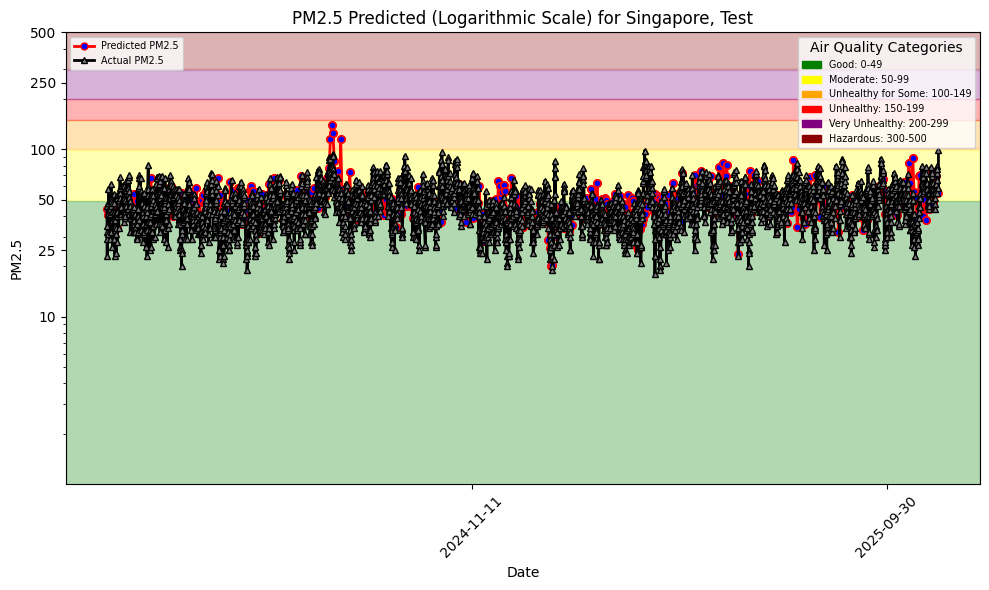

In [134]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['date']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast('Singapore', 'Test', df, file_path, hindcast=True) 
plt.show()

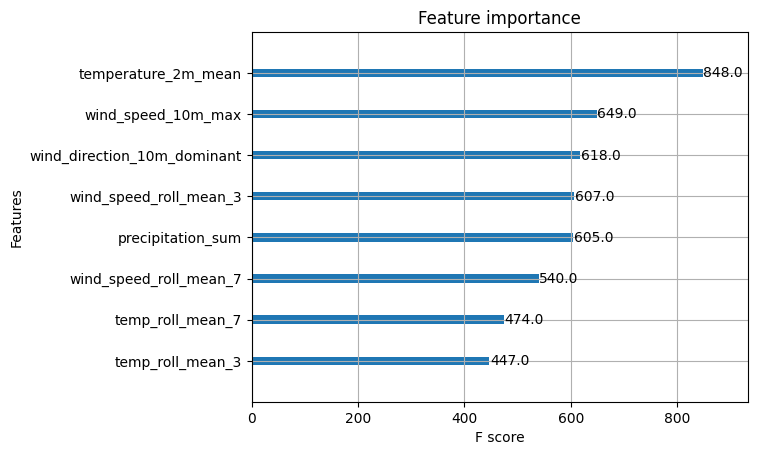

In [135]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()